In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from PIL import Image

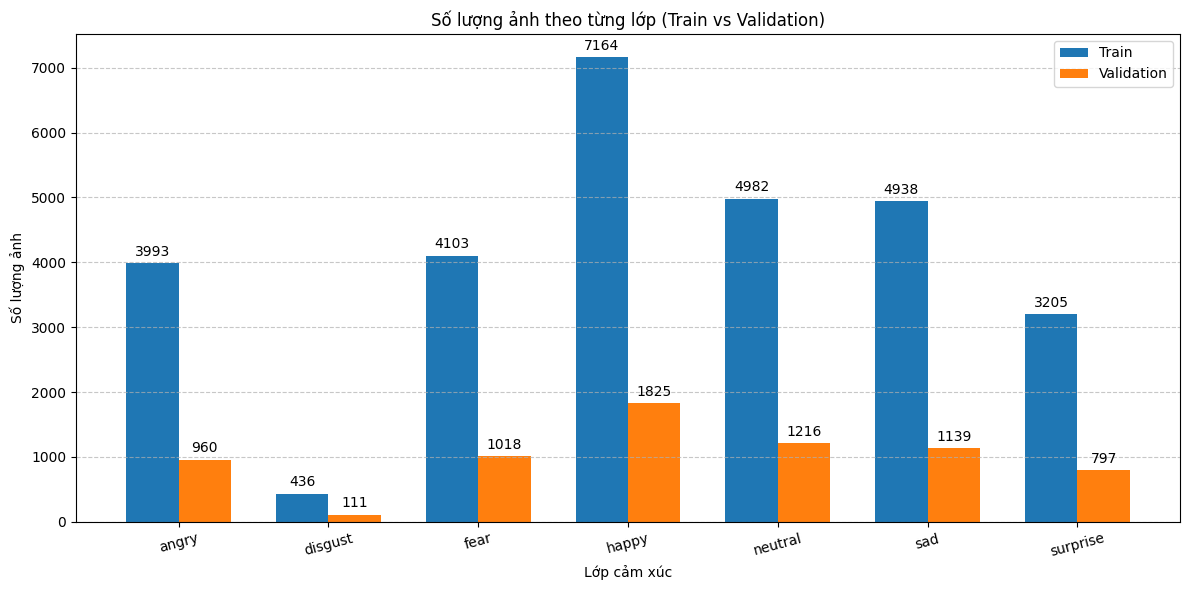

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Lấy danh sách lớp
classes = os.listdir(train_dir)
train_counts = []
val_counts = []

# Đếm ảnh
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    val_path = os.path.join(val_dir, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    val_count = len(os.listdir(val_path)) if os.path.exists(val_path) else 0

    train_counts.append(train_count)
    val_counts.append(val_count)

# Vẽ biểu đồ
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Số lượng ảnh')
ax.set_xlabel('Lớp cảm xúc')
ax.set_title('Số lượng ảnh theo từng lớp (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số lượng trên đầu mỗi cột
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm pixel lên trên
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [4]:
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Tạo các generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

# Tạo các generator cho train và validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Lưu thông tin về generator vào file JSON
generator_info = {
    "train_generator": {
        "target_size": train_generator.target_size,
        "color_mode": train_generator.color_mode,
        "batch_size": train_generator.batch_size,
        "class_mode": train_generator.class_mode,
        "num_classes": len(train_generator.class_indices),
        "class_labels": list(train_generator.class_indices.keys())
    },
    "validation_generator": {
        "target_size": validation_generator.target_size,
        "color_mode": validation_generator.color_mode,
        "batch_size": validation_generator.batch_size,
        "class_mode": validation_generator.class_mode,
        "num_classes": len(validation_generator.class_indices),
        "class_labels": list(validation_generator.class_indices.keys())
    }
}

# Lưu vào file JSON
with open('generator_info.json', 'w') as json_file:
    json.dump(generator_info, json_file, indent=4)

print("File generator_info.json đã được tạo!")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
File generator_info.json đã được tạo!


In [5]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# Khởi tạo mô hình CNN (Convolutional Neural Network)
model = Sequential()

# 1 - Lớp tích chập (Convolution Layer)
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(56, 56, 1)))  # Lớp tích chập với 64 bộ lọc kích thước 3x3, padding='same' giữ kích thước ảnh
model.add(BatchNormalization())  # Chuẩn hóa đầu ra của lớp tích chập
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(MaxPooling2D(pool_size=(2, 2)))  # Lớp pooling với kích thước cửa sổ 2x2 để giảm kích thước ảnh
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25% để giảm overfitting

# Lớp tích chập thứ 2
model.add(Conv2D(128, (5, 5), padding='same'))  # Lớp tích chập với 128 bộ lọc kích thước 5x5
model.add(BatchNormalization())  # Chuẩn hóa đầu ra
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling với kích thước cửa sổ 2x2
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25%

# Lớp tích chập thứ 3
model.add(Conv2D(512, (3, 3), padding='same'))  # Lớp tích chập với 512 bộ lọc kích thước 3x3
model.add(BatchNormalization())  # Chuẩn hóa đầu ra
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling với kích thước cửa sổ 2x2
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25%

# Lớp tích chập thứ 4
model.add(Conv2D(512, (3, 3), padding='same'))  # Lớp tích chập với 512 bộ lọc kích thước 3x3
model.add(BatchNormalization())  # Chuẩn hóa đầu ra
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling với kích thước cửa sổ 2x2
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25%

# Làm phẳng (Flatten) đầu ra từ các lớp trước để chuyển sang các lớp Fully Connected (FC)
model.add(Flatten())

# Lớp Fully Connected đầu tiên
model.add(Dense(256))  # Lớp Dense với 256 đơn vị
model.add(BatchNormalization())  # Chuẩn hóa đầu ra
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25%

# Lớp Fully Connected thứ hai
model.add(Dense(512))  # Lớp Dense với 512 đơn vị
model.add(BatchNormalization())  # Chuẩn hóa đầu ra
model.add(Activation('relu'))  # Áp dụng hàm kích hoạt ReLU
model.add(Dropout(0.25))  # Áp dụng Dropout với tỷ lệ 25%

# Lớp output (Lớp đầu ra) với 7 đơn vị (7 lớp cảm xúc), hàm kích hoạt softmax
model.add(Dense(7, activation='softmax'))

# In thông tin về mô hình
print(model.summary())

# Biên dịch mô hình với Adam optimizer và learning rate = 0.0001, hàm mất mát là categorical_crossentropy
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import math
# Định nghĩa EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Theo dõi sự thay đổi của loss trên validation
    patience=10,             # Số epoch mà mô hình có thể không cải thiện trước khi dừng
    verbose=1,               # Hiển thị thông tin khi dừng
    restore_best_weights=True # Khôi phục trọng số tốt nhất khi dừng sớm
)

# Định nghĩa ModelCheckpoint để lưu trọng số tốt nhất với phần mở rộng .h5.keras
checkpoint = ModelCheckpoint(
    "model_weights.h5.keras", 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Định nghĩa ModelCheckpoint để lưu toàn bộ mô hình với phần mở rộng .keras
model_save_checkpoint = ModelCheckpoint(
    "model_full_keras.keras",  # Tên tệp để lưu mô hình dưới định dạng .keras
    save_best_only=True,       # Lưu mô hình tốt nhất
    monitor='val_accuracy',    # Theo dõi độ chính xác trên validation
    verbose=1,
    save_weights_only=False,   # Lưu toàn bộ mô hình, bao gồm cả cấu trúc và trọng số
    mode='max'
)

# Callback để in số epoch sau mỗi epoch
epoch_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}/{epochs} finished, val_loss: {logs['val_loss']}, val_accuracy: {logs['val_accuracy']}"),
)

# Danh sách các callback
callbacks_list = [checkpoint, early_stopping, epoch_callback, model_save_checkpoint]

# Số lượng epoch huấn luyện
epochs = 20


# Tính toán steps_per_epoch và validation_steps
steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.n / validation_generator.batch_size)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # Sử dụng giá trị đã làm tròn
    epochs=epochs,  # Số epoch
    validation_data=validation_generator,
    validation_steps=validation_steps,  # Sử dụng giá trị đã làm tròn
    callbacks=callbacks_list,
    verbose=1  # Hiển thị thông tin về mỗi epoch
)

# Sau khi huấn luyện hoàn tất, lưu mô hình hoàn chỉnh (cấu trúc + trọng số) vào file .keras
model.save("CNN_model_emotion_perfect.keras")  # Lưu mô hình hoàn chỉnh vào file với định dạng .keras
print("Mô hình đã được lưu với định dạng .keras")


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.2146 - loss: 2.1031
Epoch 1: val_accuracy improved from -inf to 0.25856, saving model to model_weights.h5.keras
Epoch 1/20 finished, val_loss: 1.824739933013916, val_accuracy: 0.2585621178150177

Epoch 1: val_accuracy improved from -inf to 0.25856, saving model to model_full_keras.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 454s 1000ms/step - accuracy: 0.2146 - loss: 2.1029 - val_accuracy: 0.2586 - val_loss: 1.8247
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.2379 - loss: 1.9022
Epoch 2: val_accuracy improved from 0.25856 to 0.29677, saving model to model_weights.h5.keras
Epoch 2/20 finished, val_loss: 1.7436901330947876, val_accuracy: 0.2967732846736908

Epoch 2: val_accuracy improved from 0.25856 to 0.29677, saving model to model_full_keras.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 346s 768ms/step - accuracy: 0.2379 - loss: 1.9022 - val_accuracy: 0.2968 - val_loss: 1.7437
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step

📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.57      0.51       960
     disgust       0.55      0.32      0.41       111
        fear       0.51      0.20      0.28      1018
       happy       0.83      0.84      0.84      1825
     neutral       0.49      0.69      0.57      1216
         sad       0.50      0.39      0.44      1139
    surprise       0.65      0.80      0.72       797

    accuracy                           0.60      7066
   macro avg       0.57      0.54      0.54      7066
weighted avg       0.60      0.60      0.58      7066



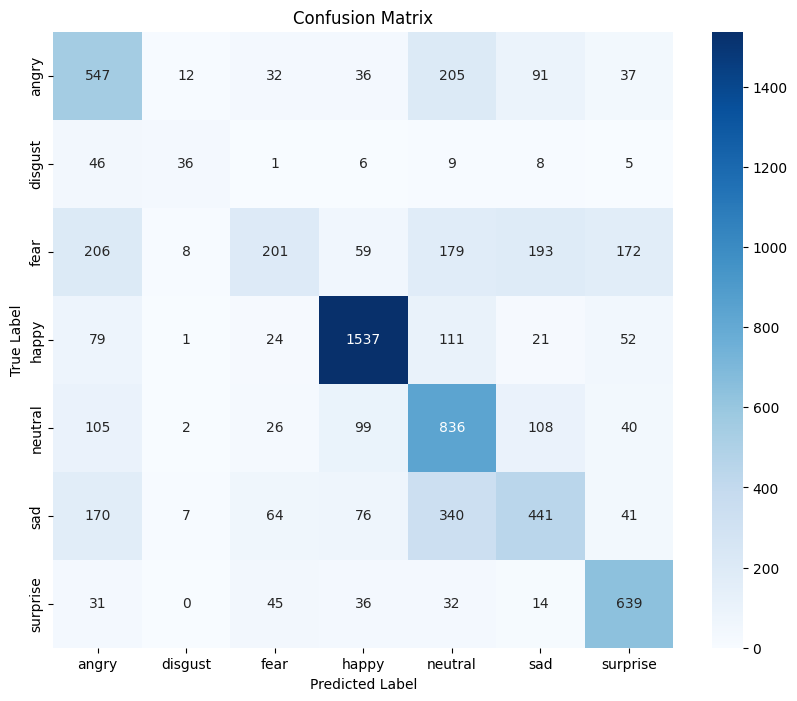

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 🧩 Bước 1: Predict trên toàn bộ validation set
# (cẩn thận, phải predict theo batch)

# Dự đoán xác suất (y_pred_prob) và lấy ra class dự đoán (y_pred_class)
y_pred_prob = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 🧩 Bước 2: Lấy ground truth (nhãn thật)
# validation_generator.classes là list các nhãn thật
y_true = validation_generator.classes

# 🧩 Bước 3: In Classification Report
target_names = list(validation_generator.class_indices.keys())

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=target_names))

# 🧩 Bước 4: Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load lại mô hình
model = load_model("full_model_notEarlyStopPart2.keras")

# Kiểm tra input shape
print("Input shape của model:", model.input_shape)

# Nếu model cần nhiều channel (RGB, v.v.)
expected_channels = model.input_shape[-1]
color_mode = "grayscale" if expected_channels == 1 else "rgb"

# Data preprocessing giống như khi train
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    'D:/DatasetDoAnCoSO/dataset_emotion/images/validation',
    target_size=(56, 56),
    color_mode=color_mode,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Đánh giá mô hình (val_loss và val_accuracy)
results = model.evaluate(test_generator, verbose=1)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

Input shape của model: (None, 56, 56, 1)
Found 7066 images belonging to 7 classes.


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 60s 536ms/step - accuracy: 0.6394 - loss: 1.2390
loss: 1.0881
compile_metrics: 0.6877


In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load model
model = load_model("full_model_notEarlyStopPart2.keras")

# Kiểm tra input shape
print("📐 Input shape của model:", model.input_shape)

# Tạo generator cho validation
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'
val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Đánh giá model
results = model.evaluate(val_generator, verbose=0)
metrics_names = model.metrics_names
metrics_dict = dict(zip(metrics_names, results))

print("📊 Danh sách metric được lưu trong model:", metrics_names)
print("🎯 Kết quả đánh giá trên tập validation:")

# In từng metric ra rõ ràng
for name, value in metrics_dict.items():
    print(f"🔹 {name}: {value:.4f}")


📐 Input shape của model: (None, 56, 56, 1)
Found 7066 images belonging to 7 classes.
📊 Danh sách metric được lưu trong model: ['loss', 'compile_metrics']
🎯 Kết quả đánh giá trên tập validation:
🔹 loss: 1.0881
🔹 compile_metrics: 0.6877
